In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from scipy.stats import boxcox

#import DL libs
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers 
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import LSTM, GRU

plt.style.use('fivethirtyeight')


plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

%matplotlib inline


In [2]:
# util function
def plot_distributions(X):
    """
    plots distribution of numerical data from dataframe
    """
    X = pd.melt(X)
    g = sns.FacetGrid(X, col="variable",  col_wrap=3, sharex=False, sharey=False)
    g = g.map(sns.distplot, "value")
    
def plot_missing_values(X):
    """
    plots missing values per column of  dataframe in a bar chart 
    """
    missing = X.isnull().sum()
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    
def spearman(frame, features=[], target='y'):
    """
    plots spearman correlation of each features with target
    """
    spr = pd.DataFrame()
    print(features)
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
    
def plot_corr_heatmap(X, title="Corr Heatmap"):
    X_corr = X.corr()
    plt.figure(figsize=(20,7))
    # Add title
    plt.title(title)
    mask = np.zeros_like(X_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(mask=mask, data=X_corr, annot=True, cmap=cmap)
    
def pairplot_with_target(X, features, target):
    def pairplot(x, y, **kwargs):
        ax = plt.gca()
        ts = pd.DataFrame({'time': x, 'val': y})
        ts = ts.groupby('time').mean()
        ts.plot(ax=ax)
        plt.xticks(rotation=90)

    f = pd.melt(X, id_vars=[target], value_vars=features)
    g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
    g = g.map(pairplot, "value", target)

## PART 1

### 1)



In [3]:
#read datasets
btc_price = pd.read_csv('../data/BTCPrice.csv', index_col=['Date'])
btc_price.columns = ['PRICE']

btc_trd_vol = pd.read_csv('../data/BTCTradeVolume.csv', index_col=['Date'])
btc_trd_vol.columns = [ 'TRD_VOLUME']

btc_miner_fees =  pd.read_csv('../data/BTCtransaction-fees.csv', index_col=['Date'])
btc_miner_fees.columns = ['MINERS_FEE']


btc_transaction_vol = pd.read_csv('../data/BTCTransactionVolume.csv', index_col=['Date'])
btc_transaction_vol.columns = ['TRAN_VOL']

btc_price_vol = pd.read_csv('../data/BTCprice-volatility.csv', index_col=['Date'])
btc_price_vol.columns = ['PRICE_VOL']

btc_miner_revenue =  pd.read_csv('../data/BTCminer-revenue.csv', index_col=['Date'])
btc_miner_revenue.columns = ['MINERS_REVENUE']

btc_difficulty = pd.read_csv('../data/BTCDifficulty.csv', index_col=['Date'])
btc_difficulty.columns = ['DIFFICULTY']

btc_transaction_per_block = pd.read_csv('../data/BTCTransactionPerBlock.csv', index_col=['Date'])
btc_transaction_per_block.columns = ['TRAN_BLOCK']

btc_hash_rate = pd.read_csv('../data/BTChash-rate.csv', index_col=['Date'])
btc_hash_rate.columns = ['HASH_RATE'] 

btc_market_cap = pd.read_csv('../data/BTCmarket-cap.csv', index_col=['Date'])
btc_market_cap.columns = ['MARKET_CAP'] 

bch_price =  pd.read_csv('../data/BCHprice.csv', index_col=['Date'])
bch_price.columns = ['BCH_PRICE']

btc_money_supply =  pd.read_csv('../data/BTCmoney-supply.csv', index_col=['Date'])
btc_money_supply.columns = ['MONEY_SUPPLY']



btc_data = pd.concat([btc_price, btc_trd_vol, btc_miner_fees, btc_transaction_vol, btc_price_vol,
                     btc_miner_revenue, btc_difficulty, btc_transaction_per_block, btc_hash_rate,
                     btc_money_supply, bch_price, btc_market_cap], axis=1, sort=True)
btc_data.index= pd.to_datetime(btc_data.index, format='%Y-%m-%d')
btc_data = btc_data.loc[(btc_data.index >= '2010-01-01') & (btc_data.index <= '2019-06-30')]

In [5]:
engineered_features = ['ma7', '14sd']
btc_data['ma7'] = btc_data['PRICE'].rolling(7).mean()
btc_data['14sd'] = btc_data['PRICE'].rolling(14).std()
base_features = list(btc_data.columns)

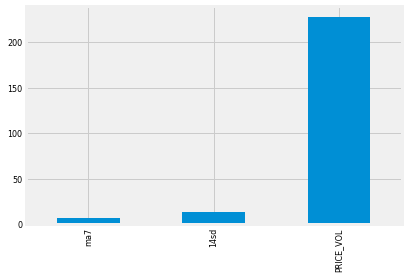

In [6]:
plot_missing_values(btc_data)


0 price does not make sense in the beginning of 2010. Its probably due to the lack of trading on exchanges at that time. It would be best to drop rows with 0 price or 0 trade volume. Since prices with 0 trading volume are also not reliable. Removing 0 price value also takes care of the missing value in the above columns.


In [7]:
btc_data = btc_data.drop(btc_data[btc_data['PRICE']==0].index)

In [8]:
btc_data.describe()

,PRICE,TRD_VOLUME,MINERS_FEE,TRAN_VOL,PRICE_VOL,MINERS_REVENUE,DIFFICULTY,TRAN_BLOCK,HASH_RATE,MONEY_SUPPLY,BCH_PRICE,MARKET_CAP,ma7,14sd
count,3240.000000,3.240000e+03,3240.000000,3.240000e+03,3240.000000,3240.000000,3.240000e+03,3240.000000,3.240000e+03,3.240000e+03,3240.000000,3.240000e+03,3240.000000,3240.000000
mean,1784.235752,1.291471e+08,61.613730,2.034392e+05,76.235959,4399.985644,1.041392e+12,883.314062,7.608236e+06,1.287301e+07,436.786290,2.977832e+10,1773.277805,118.838675
std,3097.652417,3.324501e+08,111.997930,2.528356e+05,50.449536,2519.248731,2.101884e+12,765.905471,1.525644e+07,3.899653e+06,538.467441,5.268743e+10,3076.141552,288.304513
min,0.060900,5.131510e+01,0.000000,6.221000e+03,0.000000,1242.089114,5.120000e+02,1.000000,3.970459e-03,3.739600e+06,0.060000,2.308860e+05,0.010986,0.000473
25%,13.712525,6.742530e+05,12.662478,1.073318e+05,39.107889,2166.924622,3.054628e+06,224.000000,2.176505e+01,1.031562e+07,13.440000,1.240693e+08,13.619407,1.091907
50%,385.080000,7.818132e+06,24.843805,1.719355e+05,64.459420,3830.998224,4.127287e+10,632.500000,3.110143e+05,1.375114e+07,287.605000,5.440071e+09,382.347143,12.338536
75%,1230.232719,8.482045e+07,52.676742,2.522833e+05,99.656925,5903.135531,4.996359e+11,1536.395369,3.697014e+06,1.626728e+07,606.700000,1.996838e+10,1204.589130,68.669680
max,19498.683333,5.352016e+09,1495.748916,5.825066e+06,272.447767,15371.520742,7.934713e+12,2762.540984,6.219192e+07,1.778861e+07,3810.470000,3.214197e+11,18106.656476,2668.099182


### 2)

Text(0.5, 0, 'date')

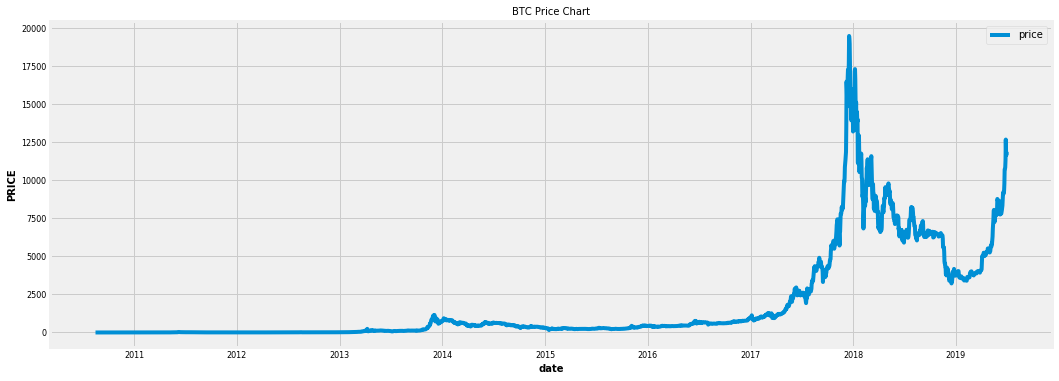

In [9]:
plt.figure(figsize=(16,6))
plt.title('BTC Price Chart')
sns.lineplot(btc_data.index, btc_data['PRICE'], label='price')
plt.xlabel('date')


### 2 & 3)

In [10]:
#feature engineering
# lets split our data set before we do analysis on data set to make testing phase completely independent
target = 'PRICE'
train_mask = (btc_data.index >= '2010-01-01') & (btc_data.index <= '2018-06-30')
valid_mask = (btc_data.index >= '2018-07-01') & (btc_data.index <= '2018-12-31')
test_mask = (btc_data.index >= '2019-01-01') & (btc_data.index <= '2019-06-30')

X_train_act =  btc_data.loc[train_mask][base_features]
y_train_act =  pd.DataFrame(btc_data.loc[train_mask][target])

X_valid_act =  pd.DataFrame(btc_data.loc[valid_mask][base_features])
y_valid_act = pd.DataFrame(btc_data.loc[valid_mask][target])

X_test_act =  btc_data.loc[test_mask][base_features]
y_test_act =  pd.DataFrame(btc_data.loc[test_mask][target])

missing = X_train_act.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)

In [11]:

#using constant imputer for price volatility and standard scaler for normalization
constant_imputer = SimpleImputer(strategy='constant')

#normalizer
normalizer = StandardScaler()
y_normalizer = StandardScaler()

def preprocessing_pipeline(X, train=False):
    ind = X.index
    # Here we only scale the train dataset for fitting normalizer to prevent data leakage
    if  train:
        X = pd.DataFrame(constant_imputer.fit_transform(X), columns=base_features)
        X = pd.DataFrame(normalizer.fit_transform(X), columns=base_features)
    else:
        X = pd.DataFrame(constant_imputer.transform(X), columns=base_features)
        
        X = pd.DataFrame(normalizer.transform(X), columns=base_features)
    X.index = ind
    return X
        
def y_preprocessing_pipeline(y, train=False):
    ind = y.index
    if  train:
        y = pd.DataFrame(y_normalizer.fit_transform(y), columns=[target])
    else: 
        y = pd.DataFrame(y_normalizer.transform(y), columns=[target])
    y.index = ind
    return y



In [12]:
X_train = preprocessing_pipeline(X_train_act, train=True)
X_valid = preprocessing_pipeline(X_valid_act, train=False)
X_test = preprocessing_pipeline(X_test_act, train=False)

y_train = y_preprocessing_pipeline(y_train_act, train=True)
y_valid = y_preprocessing_pipeline(y_valid_act, train=False)
y_test = y_preprocessing_pipeline(y_test_act, train=False)

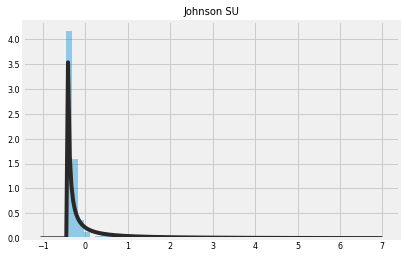

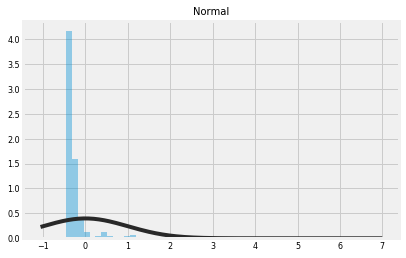

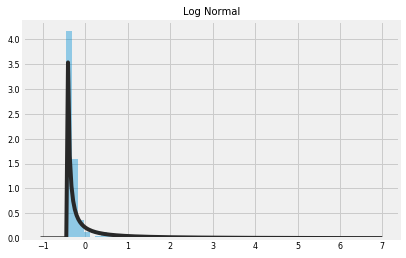

In [13]:
import scipy.stats as st
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y_train, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y_train, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y_train, kde=False, fit=st.lognorm)

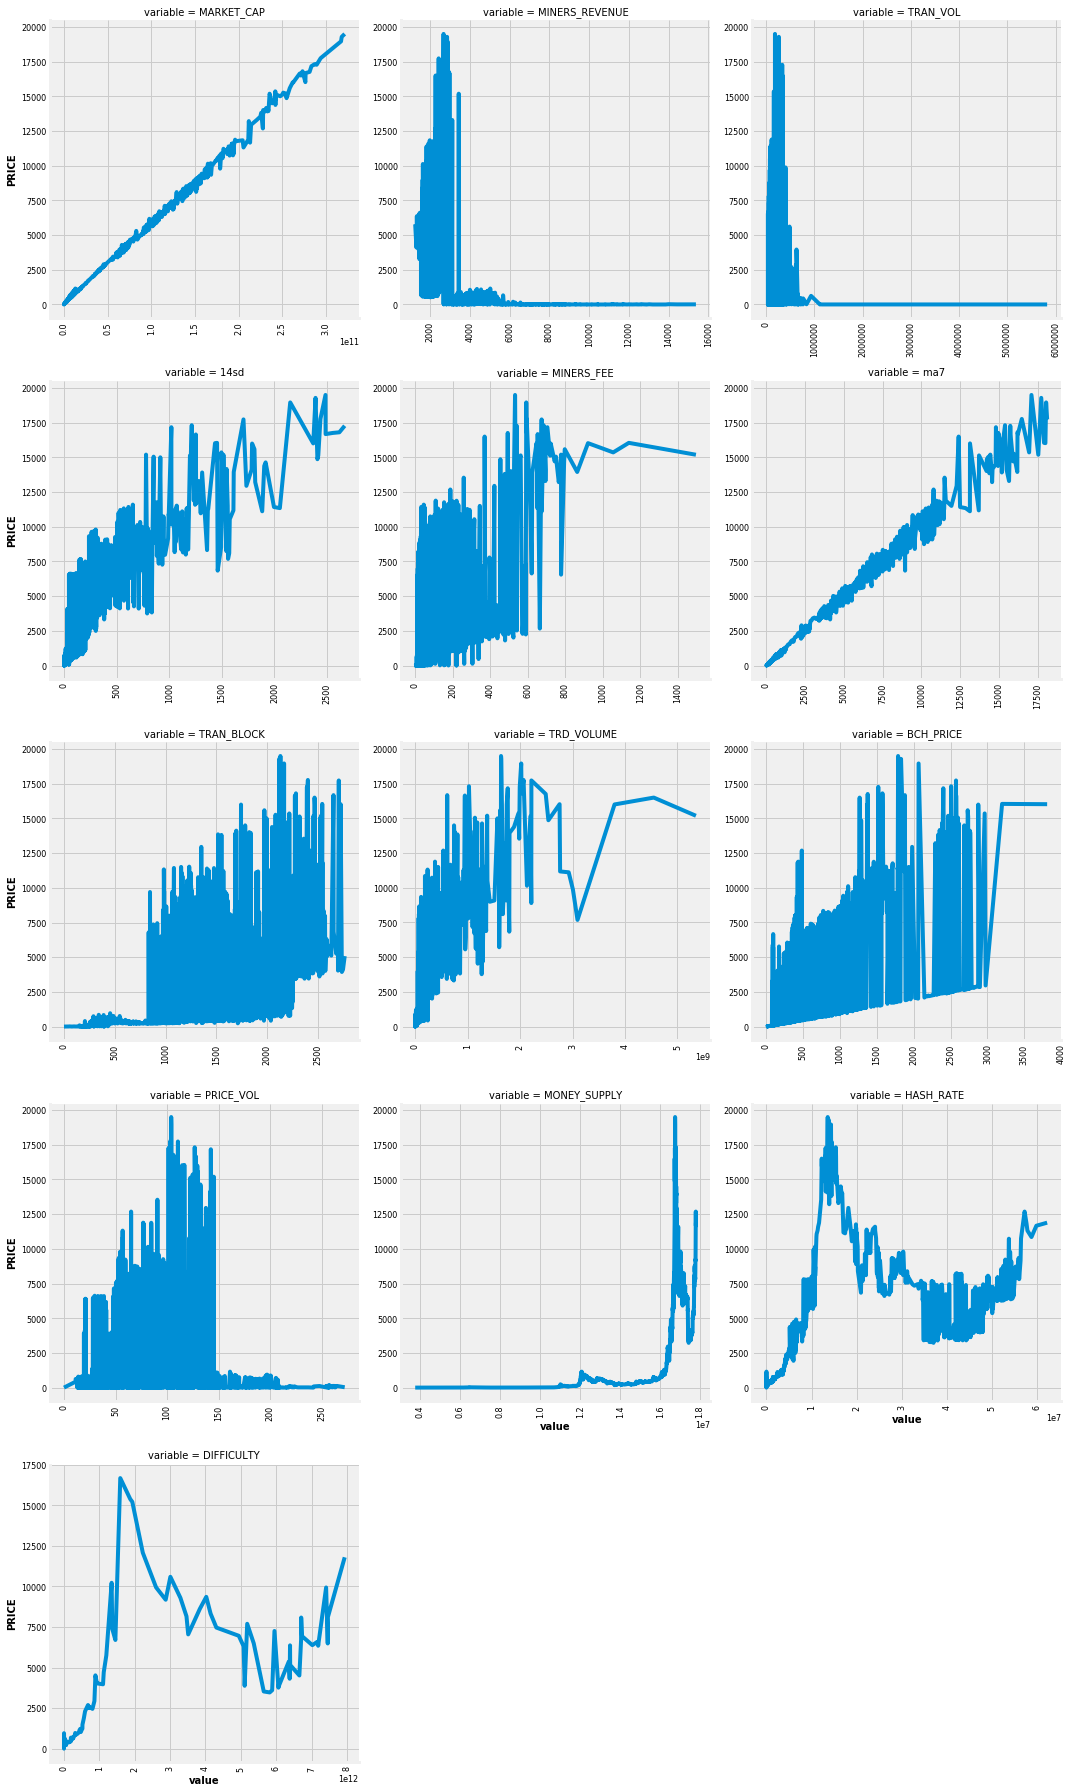

In [13]:
pairplot_with_target(btc_data, list(set(base_features) - set(['PRICE'])), 'PRICE')

We can see some linear relationship of target variable with features

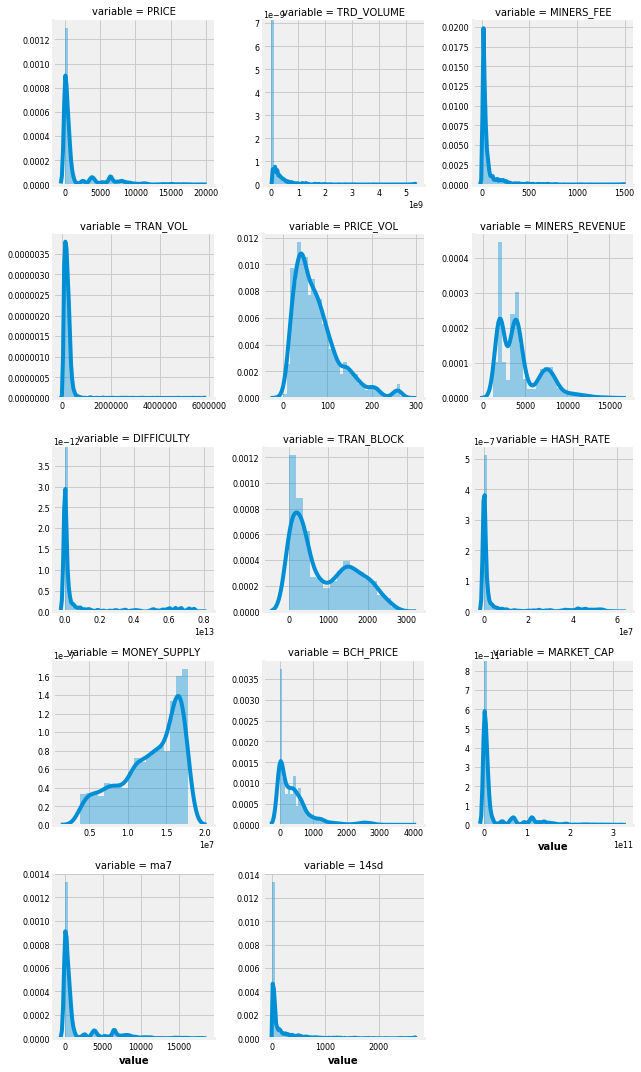

In [14]:
plot_distributions(btc_data)

Prices, price_vol, hash_rate, TRAN_VOL appear to be following lognormal distribution. We can make log transformation to make distributions bit symmetrical

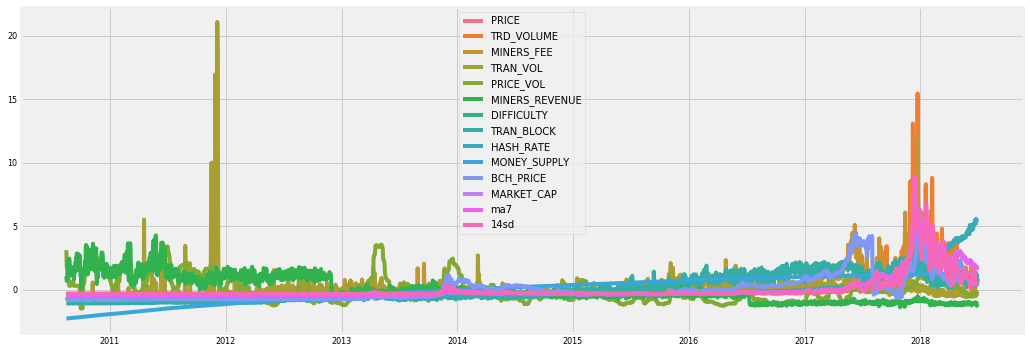

In [ ]:
#plot all columns in same chart 
plt.figure(figsize=(16,6))

sns.lineplot(data=X_train, dashes=False)

### 4)

,PRICE,TRD_VOLUME,MINERS_FEE,TRAN_VOL,PRICE_VOL,MINERS_REVENUE,DIFFICULTY,TRAN_BLOCK,HASH_RATE,MONEY_SUPPLY,BCH_PRICE,MARKET_CAP,ma7,14sd
PRICE,1.000000,0.854427,0.628143,-0.013784,0.110893,-0.412486,0.811061,0.531868,0.815741,0.483307,0.643371,0.999648,0.995929,0.912814
TRD_VOLUME,0.854427,1.000000,0.631983,0.017290,0.127128,-0.296069,0.600732,0.442263,0.605587,0.360243,0.511928,0.851829,0.856783,0.880236
MINERS_FEE,0.628143,0.631983,1.000000,0.089208,0.014377,-0.386593,0.298670,0.646756,0.300511,0.446384,0.729353,0.621272,0.632284,0.626682
TRAN_VOL,-0.013784,0.017290,0.089208,1.000000,-0.038710,-0.086158,-0.041675,0.135970,-0.041525,0.115920,0.048378,-0.013741,-0.015068,-0.000733
PRICE_VOL,0.110893,0.127128,0.014377,-0.038710,1.000000,0.418934,0.043356,-0.314976,0.045488,-0.436119,-0.047536,0.110489,0.112108,0.155599
MINERS_REVENUE,-0.412486,-0.296069,-0.386593,-0.086158,0.418934,1.000000,-0.409704,-0.754873,-0.407848,-0.902853,-0.592617,-0.408425,-0.411962,-0.312381
DIFFICULTY,0.811061,0.600732,0.298670,-0.041675,0.043356,-0.409704,1.000000,0.439714,0.998796,0.468587,0.502924,0.819130,0.819398,0.627728
TRAN_BLOCK,0.531868,0.442263,0.646756,0.135970,-0.314976,-0.754873,0.439714,1.000000,0.437955,0.852471,0.710018,0.529818,0.526475,0.435275
HASH_RATE,0.815741,0.605587,0.300511,-0.041525,0.045488,-0.407848,0.998796,0.437955,1.000000,0.467762,0.504788,0.823734,0.823691,0.636776
MONEY_SUPPLY,0.483307,0.360243,0.446384,0.115920,-0.436119,-0.902853,0.468587,0.852471,0.467762,1.000000,0.657277,0.479434,0.483101,0.376030


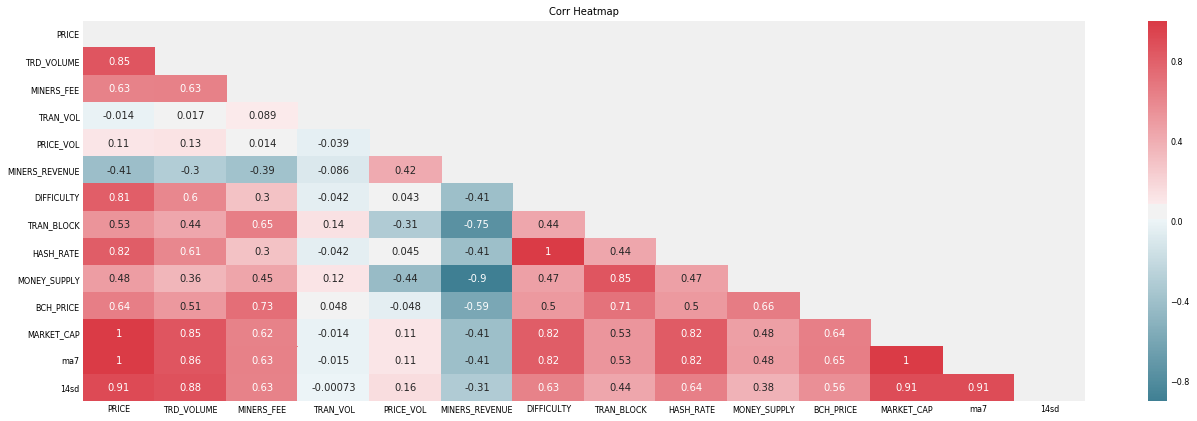

In [ ]:
plot_corr_heatmap(X_train)
X_train.corr()

In [1]:
## pair plot of all variable with each other and target
sns.pairplot(btc_data, size = 3.5)

NameError: name 'sns' is not defined

highly correlated

1)Money supply and transections per block 

2)BCH price and transections per block 

4) hashrate and difficulty are almost perfectly correlated(we should drop one of thesse)

5) miners fee and bch price

6) transections per block and bch price

Negatively corr

1) Miners revenue and transections per block 

2) Miners revenue and money supply(number of bitcoins)


We should drop difficulty as it is highly correlated with hashrate and trd volume.


In [14]:
X_train = X_train.drop(['DIFFICULTY'], axis=1)
X_test = X_test.drop(['DIFFICULTY'], axis=1)
X_valid = X_valid.drop(['DIFFICULTY'], axis=1)
base_features = list(set(base_features )- set(['DIFFICULTY']))

## Part 2

Basic Pre processing and split done in sub parts 2,3 of Part 1.

Now, lets do feature engineering to derive more predictors from past 28 days.
First lets concat features from last 28 days and also create 


In [15]:
#### data processing Utils
def create_lagged_features(X,features, lag=3, dropna=False):
    """
    This function creates the lagged feature dataframe specifically useful for time series modelling
    """
    c_X = X
    lagged_dfs = [ c_X.shift(i).add_suffix('_' + str(i)) for i in range(lag)]
    lagged_dfs = pd.concat(lagged_dfs, axis=1)
    if dropna:
        lagged_dfs = lagged_dfs.dropna()
    return lagged_dfs

def create_leading_targets(X, lead=3, dropna=False):
    """
    This function creates leading targets specifically useful for predicting over multiple periods
    """
    leading_df = [ X.shift(-i).add_suffix('_' + str(i)) for i in range(1, lead+1)]
    leading_df =pd.concat(leading_df, axis=1)
    if dropna:
        leading_df = leading_df.dropna()
    return leading_df

In [16]:
lag = 28

In [17]:
X_train_lagged = create_lagged_features(X_train, base_features,lag=lag)[lag:-7]
y_train_leading = create_leading_targets(pd.DataFrame(y_train), lead=7)[lag:-7]

X_valid_lagged = create_lagged_features(X_valid, base_features,lag=lag)[lag:-7]
y_valid_leading = create_leading_targets(pd.DataFrame(y_valid), lead=7)[lag:-7]


X_test_lagged = create_lagged_features(X_test, base_features, lag=lag)[lag:-7]
y_test_leading = create_leading_targets(pd.DataFrame(y_test), lead=7)[lag:-7]

we will start trading after 28 days and also stop trading 7 days before to avoid handling NaN cases 

Lets verify wheather input features are based on 28 days look back period and targets on next periods

On 2018-06-19, we are using the prices and features from past 28 days to predict next 7 days prices. PRICE_1 is next day price and price 0 is the current day price.

## Part 3

Now that our data sets are ready lets start training.

But before that lets create score function

In [ ]:
def get_model_score(model, X, y_true):
    y_pred = model.predict(X)
    unnormalized_pred = pd.DataFrame(y_normalizer.inverse_transform(y_pred))
    unnormalized_true = pd.DataFrame(y_normalizer.inverse_transform(y_true))
    return mean_absolute_error(unnormalized_pred, unnormalized_true)


### 1) Average and Last Value model

In [ ]:
def get_avg_model_preds(data, target):
    y_preds = btc_data[target].rolling(28).mean().loc[y_valid_leading.index]
    return pd.concat([y_preds]*7, axis=1) 

def get_last_val_preds(data, target):
    y_preds = data[target].shift(1).loc[y_valid_leading.index]
    return pd.concat([y_preds]*7, axis=1) 

last_val_preds = get_last_val_preds(btc_data, target)
avg_model_preds = get_avg_model_preds(btc_data, target)
unnorm_y_valid = y_normalizer.inverse_transform(y_valid_leading)
print("avg benchmark score: ", mean_absolute_error(unnorm_y_valid, avg_model_preds))
print("last val benchmark score: ", mean_absolute_error(unnorm_y_valid, last_val_preds))


plt.figure(figsize=(16,6))
plt.title('Average Model Validation Predictions(t+1)')
sns.lineplot(y_valid_leading.index, avg_model_preds.iloc[:,0], label='predicted price')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')
plt.xlabel('date')



In [ ]:
plt.figure(figsize=(16,6))
plt.title('Last Value Validation Predictions(T+1)')
sns.lineplot(y_valid_leading.index, last_val_preds.iloc[:,0], label='predicted price')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')

plt.xlabel('date')


### 2)  simple neural network 

## Tune N (look back period)

In [ ]:
from tensorflow import set_random_seed
from keras.regularizers import l1

set_random_seed(2)
# imp_features = ['PRICE_0', 'PRICE_1', 'PRICE_2', 'PRICE_3', 'PRICE_4', 'PRICE_5', 'PRICE_6', 'PRICE_7',
#                 'HASH_RATE_0','MINERS_REVENUE_0',
#                 'ma7_0', '14sd_0']
# X_train_lagged_new = X_train_lagged[imp_features]
# X_valid_lagged_new = X_valid_lagged[imp_features]

scores = {'N': [],
          'mae': []}
def train_simple_nn(X_train, y_train, X_valid, y_valid, lag=28, epochs=10, batch_size=50):
    X_train_lagged = create_lagged_features(X_train, base_features,lag=lag)[lag:-7]
    y_train_leading = create_leading_targets(pd.DataFrame(y_train), lead=7)[lag:-7]
    X_valid_lagged = create_lagged_features(X_valid, base_features,lag=lag)[lag:-7]
    y_valid_leading = create_leading_targets(pd.DataFrame(y_valid), lead=7)[lag:-7]
    simple_nn = Sequential()
    simple_nn.add(Dense(50, input_dim=X_train_lagged.shape[1], activation='relu'))
    simple_nn.add(Dense(50, activation='relu'))
    simple_nn.add(Dense(7))
    simple_nn.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
    h = simple_nn.fit(X_train_lagged, y_train_leading, verbose=0,
                      epochs=epochs, batch_size=batch_size)
    curr_score = get_model_score(simple_nn, X_valid_lagged, y_valid_leading)
    return curr_score
    
    
n = range(3, 28, 3)
for i in n:
    curr_score = train_simple_nn(X_train, y_train, X_valid, y_valid, lag=i, epochs=10, batch_size=50)  
    scores['N'].append(i)
    scores['mae'].append(curr_score)

In [ ]:
pd.DataFrame(scores)

## Tuning epoch and batch size

In [ ]:
epochs = range(10, 100, 20)
batch = range(20, 200, 30)
scores = {'epoch': [],
          'batch': [],
          'mae': []}
for e in epochs:
    for b in batch:
        print(e, b)
        curr_score = train_simple_nn(X_train, y_train, X_valid, y_valid, lag=6, epochs=e, batch_size=b)  
        scores['epoch'].append(e)
        scores['batch'].append(b)
        scores['mae'].append(curr_score)
        

In [ ]:
pd.DataFrame(scores)

### Final tuned model
N = 6

e = 50

batch_size = 20

In [ ]:
lag=6

X_train_lagged = create_lagged_features(X_train, base_features,lag=lag)[lag:-7]
y_train_leading = create_leading_targets(pd.DataFrame(y_train), lead=7)[lag:-7]

X_valid_lagged = create_lagged_features(X_valid, base_features,lag=lag)[lag:-7]
y_valid_leading = create_leading_targets(pd.DataFrame(y_valid), lead=7)[lag:-7]

In [ ]:
X_test_lagged = create_lagged_features(X_test, base_features, lag=lag)[lag:-7]
y_test_leading = create_leading_targets(pd.DataFrame(y_test), lead=7)[lag:-7]
simple_nn = Sequential()
simple_nn.add(Dense(50, input_dim=X_train_lagged.shape[1], activation='relu'))
simple_nn.add(Dense(50, activation='relu'))
simple_nn.add(Dense(7))
simple_nn.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
h = simple_nn.fit(X_train_lagged, y_train_leading, epochs=50, batch_size=20,
                  validation_data=(X_valid_lagged, y_valid_leading), shuffle=False)

In [ ]:
y_valid_pred = simple_nn.predict(X_valid_lagged)

In [ ]:
print("simple nn un-normalized validation mae score: ",
      get_model_score(simple_nn, X_valid_lagged, y_valid_leading))

In [ ]:
plt.plot(h.history['loss'], label='SimpleNN train', color='brown')
plt.plot(h.history['val_loss'], label='SimpleNN valid', color='blue')
plt.legend()
plt.show()

In [ ]:
# plot actual and predicted value for N+1 period

In [ ]:
unnormalised_y_valid_pred = y_normalizer.inverse_transform(y_valid_pred)
unnorm_y_valid = y_normalizer.inverse_transform(y_valid_leading)
plt.figure(figsize=(16,6))
plt.title('Simple NN Model Validation Predictions(t+1)')
sns.lineplot(y_valid_leading.index, unnormalised_y_valid_pred[:,0], label='predicted price t+1')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')
plt.xlabel('date')


score on validation set

In [ ]:
scores = simple_nn.evaluate(X_valid_lagged, y_valid_leading, verbose=0)
print("Accuracy: " + str(scores))

In [ ]:
# saving normalizer 
from sklearn.externals import joblib 

In [ ]:
joblib.dump(y_normalizer, 'price_normalizer.pkl') 

In [ ]:
#saving deep learning model

In [ ]:
joblib.dump(simple_nn, 'simple_nn.pkl') 

In [ ]:
X_train_lagged.to_csv('X_train_lagged.csv')
y_train_leading.to_csv('y_train_leading.csv')

X_valid_lagged.to_csv('X_valid_lagged.csv')
y_valid_leading.to_csv('y_valid_leading.csv')

X_test_lagged.to_csv('X_test_lagged.csv')
y_test_leading.to_csv('y_test_leading.csv')

### 7). (bonus) 
### Build a classic time series model ARIMA, and VAR(Vector AutoRegression), calculate train and validation loss

In [5]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

#### In this part, we don't need cross-validation set to tune hyper-parameters, that's why we merge vaildation set and test set

In [6]:
X_valid_ts = pd.concat([X_valid,X_test])
y_vaild_ts = pd.concat([y_valid,y_test])

X_valid_ts.shape

NameError: name 'X_valid' is not defined

### 7.1) ARIMA models:

**Step1: Check for Stationarity and Make the Time Series Stationary**

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

adfuller_test(X_train['PRICE'], name=X_train.columns[0])  

The PRICE time-series is **non-stationary**, we take first-order difference,and re-run ADF test on differenced series.

In [ ]:
# 1st-order difference
X_train_price_diff1= X_train['PRICE'].diff().dropna()
adfuller_test(X_train_price_diff1, name='PRICE')

Right now, the 'PRICE' time series is **stationary** 

**Step2: Using ARIMA model**

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(X_train['PRICE'].values.squeeze(), lags=40)
plt.show()

In [ ]:
sm.graphics.tsa.plot_acf(X_train_price_diff1.values.squeeze(), lags=40)
plt.show()

#### Using ARIMA with dynamic regression, which is an auto_ARIMA
auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [ ]:
# !pip install pmdarima

In [ ]:
import pmdarima as pm

model = pm.auto_arima(X_train['PRICE'].values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # the difference order is 1
                      seasonal=False,   # No Seasonality
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

In [ ]:
model.plot_diagnostics(figsize=(14,8))
plt.show()

**Plot interpretation:**

**Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right:** The density plot suggest normal distribution with mean zero.

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

Overall, it seems to be a good fit. Let’s forecast.

In [ ]:
# Forecast
n_periods = X_valid_ts['PRICE'].shape[0]
df = X_train['PRICE']
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = X_valid_ts.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE# MAE
    return  mae, rmse

# compute MAE
mae ,rmse = forecast_accuracy(fc_series, X_valid_ts['PRICE']) 
print('Forecast Accuracy of Price using ARIMA(5,1,5): \n MAE =',round(mae,4))
print('RMSE =', round(rmse,4))

# Plot
plt.figure(figsize=(13,8))
plt.plot(df)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of PRICE")
plt.show()

### 7.2) VAR models:

**Step1: Testing Causation using Granger’s Causality Test**

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(X_train, variables = X_train.columns)

Interpret the p-values in the above table:

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).
Looking at the P-Values in the above table,we can pretty much observe that all the variables (time series) in the system are interchangeably causing each other(P-Values smaller than 0.05).

This makes this system of multi time series a good candidate for using VAR models to forecast.

**Step2: Checking cointegration**

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(X_train)

**Step3: Check for Stationarity and Make the Time Series Stationary**

In [ ]:
# ADF Test on each column       
for name, column in X_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

Most of the time series are **non-stationary**, especially the "Price", then we take first-order difference,and Re-run ADF test on each differenced series.

In [ ]:
# 1st difference
X_train_diff1= X_train.diff().dropna()
for name, column in X_train_diff1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

Right now, all time series are **stationary** except "MONEY_SUPPLY"

**Step4: Select the Order (P) of VAR model**

In [ ]:
model = VAR(X_train_diff1)
x = model.select_order(maxlags=6)
x.summary()

Since the explicitly computed AIC is the lowest at lag 6, we choose the selected order as 6.

**Step5: Train the VAR Model of Selected Order(p=6)**

In [ ]:
model_fitted = model.fit(6)
model_fitted.summary()

**Step 6: Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic**

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(X_train_diff1.columns, out):
    print(col, ':', round(val, 2))


The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

The serial correlation seems quite alright. Let’s proceed with the forecast.

**Step7: Forecast using VAR model**

In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input =X_train_diff1.values[-lag_order:]

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=X_valid_ts.shape[0])
X_forecast_diff1 = pd.DataFrame(fc, index=X_valid_ts.index, columns=X_valid_ts.columns + '_1d')
X_forecast_diff1.tail()

Invert the transformation(de-order) to get the real forecast:

In [ ]:
def invert_transformation(df_train, df_forecast, first_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

X_forecast = invert_transformation(X_train, X_forecast_diff1, first_diff=True)        
X_forecast.iloc[:,13:].tail()


Plot of Forecast vs Actuals:

In [ ]:
fig, axes = plt.subplots(nrows=int(len(X_train.columns)/2), ncols=2, dpi=120, figsize=(10,10))
for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    X_forecast[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    X_valid_ts[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
mae ,rmse = forecast_accuracy(X_forecast['PRICE_forecast'].values, X_valid_ts['PRICE'].values) 
print('Forecast Accuracy of Price using VAR: \n MAE =',round(mae,4))
print('RMSE =', round(rmse,4))